In [1]:
from src import get_azure_openai_model, get_azure_openai_chat_model, create_vector_store

model = get_azure_openai_chat_model()
vector_store = create_vector_store()

In [2]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader

urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]

docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=500, chunk_overlap=50
)
doc_splits = text_splitter.split_documents(docs_list)

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [2]:
import os
from langchain_community.document_loaders import TextLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter

# Load .txt files

txt_folder_path = r"C:\Users\newac\OneDrive\Desktop\ocr_test_data\ocr_text"
txt_files = [f for f in os.listdir(txt_folder_path) if f.endswith('.txt')]

txt_docs = []
for txt_file in txt_files:
    loader = TextLoader(os.path.join(txt_folder_path, txt_file))
    txt_docs.extend(loader.load())
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=1000, chunk_overlap=100
)
# Split the text documents into chunks
txt_doc_splits = text_splitter.split_documents(txt_docs)

# Add the text chunks to the vector store
_ = vector_store.add_documents(documents=txt_doc_splits)

In [2]:
# Load PDFs
from langchain_community.document_loaders import PyPDFLoader
import os

folder_path = "papers"
pdf_files = [f for f in os.listdir(folder_path) if f.endswith('.pdf')]

pages = []
for pdf_file in pdf_files:
    loader = PyPDFLoader(os.path.join(folder_path, pdf_file))
    async for page in loader.alazy_load():
        pages.append(page)

In [3]:
# Add docs to vector store
# Index chunks
# _ = vector_store.add_documents(documents=doc_splits)

# Add pdf pages to vector store
_ = vector_store.add_documents(documents=pages)

In [4]:
# Retrival
retriever = vector_store.as_retriever(search_kwargs={"k": 5})

we need to break the task into sections and define nodes for each step:

- Retrieve Node – Fetch relevant documents.
- Grade Node – Evaluate document relevance.
- Decision: Docs Relevant? – If yes, move to generation; if no, re-write the question.
- Generate Node – Generate a response.
- Decision: Hallucinations? – If hallucinations are detected, loop back to generation.
- Decision: Answers Question? – If the response is valid, return the answer; otherwise, loop back.

In [5]:
#### Grader retrieval
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_core.output_parsers import StrOutputParser


# Data model
class GradeDocuments(BaseModel):
    """Binary score for relevance check on retrieved documents."""

    binary_score: str = Field(
        description="Documents are relevant to the question, 'yes' or 'no'"
    )


# LLM with function call
llm = model
structured_llm_grader = llm.with_structured_output(GradeDocuments)

# Prompt
system = """You are a grader assessing relevance of a retrieved document to a user question. \n 
    It does not need to be a stringent test. The goal is to filter out erroneous retrievals. \n
    If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question.  \n"""
grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Retrieved document: \n\n {document} \n\n User question: {question}"),
    ]
)

retrieval_grader = grade_prompt | structured_llm_grader #| StrOutputParser()
question = "Why does Harry accuse Remus Lupin of being a coward?"
docs = retriever.get_relevant_documents(question)
doc_txt = docs[1].page_content

print(retrieval_grader.invoke({"question": question, "document": docs}))






c:\Users\newac\OneDrive\Desktop\Master\.venv\Lib\site-packages\IPython\core\interactiveshell.py:3667: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain_core.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain_core.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are working in a code base that has not been fully upgraded to pydantic 2 yet. 	from pydantic.v1 import BaseModel

  exec(code_obj, self.user_global_ns, self.user_ns)
c:\Users\newac\OneDrive\Desktop\Master\.venv\Lib\site-packages\langchain_openai\chat_models\base.py:1354: UserWarning: Received a Pydantic BaseModel V1 schema. This is not supported by method="json_schema". Please use method="function_calling" or specify schema via JSON Schema or Pydantic V2 BaseMode

binary_score='yes'


### Graph testing:

In [6]:
from typing import List, Optional
from langgraph.graph import END, StateGraph, START
from typing_extensions import TypedDict
from langchain import hub


class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        documents: list of documents
    """

    question: str
    generation: str
    documents: List[str]
    answer_grade: Optional[str]

In [21]:
#### nodes
def retrieve(state):
    """
    Retrieve relevant documents for the given question.
    """
    print("---Retrieving documents---")
    question = state["question"]

    docs = retriever.get_relevant_documents(question)
    return {"question": question, "documents": docs}


def generate(state):
    """
    Generate a very concise answer to the question.
    """
    print("---Generating answer---")
    question = state["question"]
    documents_from_state = state["documents"]

    # Format documents for context.
    # Assumes documents_from_state is a list of dictionaries,
    # where each dictionary has a "document" key holding a Document object.
    context_str = "\n\n".join(
        [item["document"].page_content for item in documents_from_state if "document" in item and hasattr(item["document"], "page_content")]
    )

    # Prompt for very concise answers
    # The original "rlm/rag-prompt" asks for "Use three sentences maximum and keep the answer concise."
    # This custom prompt emphasizes "VERY concise, ideally one or two sentences."
    concise_prompt = ChatPromptTemplate.from_messages([
        ("system", "You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Keep your answer VERY concise. "),
        ("human", "Question: {question}\nContext: {context}\nAnswer:")
    ])

    # Ensure 'model' is defined in the global scope or passed to this function
    # model = get_azure_openai_chat_model() # Or however it's made available

    rag_chain = concise_prompt | model | StrOutputParser()

    generation = rag_chain.invoke({"context": context_str, "question": question})
    return {"documents": documents_from_state, "question": question, "generation": generation}


def grade_documents(state):
    """
    Grade the relevance of retrieved documents.
    """
    print("---Grading documents---")
    question = state["question"]
    documents = state["documents"]

    graded_docs = []
    for doc in documents:
        # print("i am hereee")
        result = retrieval_grader.invoke({"question": question, "document": doc.page_content})
        print(result)
        grade = result.binary_score
        if grade == "yes":
            graded_docs.append({"document": doc, "grade": result})

    return {"question": question, "documents": graded_docs}



    



In [8]:
### edge
def decide_generation(state):
    """
    Decide whether to generate an answer based on the graded documents.
    """
    print("---Deciding whether to generate an answer---")

    question = state["question"]
    documents = state["documents"]

    if len(documents) > 0:
        return "generate"
    else:
         print("no relevant document found, maybe rephrase the question")
         return "end"


In [22]:
# Build the graph
graphA = StateGraph(GraphState)
# graph.add_node(START, "retrieve")
graphA.add_node("retrieve", retrieve)
graphA.add_node("generate", generate)
graphA.add_node("grade_documents", grade_documents)

# # Add edges (transitions)
graphA.add_edge(START, "retrieve")
# graph.add_edge("retrieve", "generate")
graphA.add_edge("retrieve", "grade_documents")
graphA.add_conditional_edges("grade_documents", decide_generation,{
    "generate": "generate",
    "end": END
})
graphA.add_edge("generate", END)


# Compile the graph
graph_runnable = graphA.compile()

from IPython.display import Image, display

try:
    display(Image(graph_runnable.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass






In [ ]:
inputs = {"question": "advice for an child having heart attack no cpr needed"}
for output in graph_runnable.stream(inputs):
    for key, value in output.items():
        # Node
        print(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    print("\n---\n")

# Final generation
print(value["generation"])

In [31]:
questions = [
    "Why does Harry accuse Remus Lupin of being a coward?",
    "Who is R.A.B.?",
    "According to legend, what would a person become if he could assemble the Deathly Hallows?",
    "What is Ariana Dumbledore rumored to be?",
    "What is written on Harrys parents gravestone?",
    "Why does Krum want to fight Xenophilius Lovegood?",
    "Why does Voldemort seek the Elder Wand?",
    "Whose eye does Harry see in his magic mirror shard?",
    "What is inside the Snitch that Dumbledore leaves Harry?",
    "Who does Voldemort initially borrow a wand from in hopes of defeating Harry?",
    # "Where do Harry, Ron, and Hermione first stay during their journey to find the Horcuxes?",
    # "Who becomes the new Headmaster at Hogwarts?",
    # "Which character does Harry take the appearance of during his visit to the Ministry of Magic?",
    # "What type of Patronus appears to lead Harry to the Sword of Godric Gryffindor?",
    # "Who accidentally breaks Harry's wand?",
    # "Where do Harry, Ron, and Hermione venture to find Hufflepuff's Cup?",
    # "Who tells Harry, Hermione, and Ron the tale of the Deathly Hallows?",
    # "Where is the gravesite of James and Lily Potter located?"
]

In [26]:
# Run the graph
for question in questions:
    initial_state = {"question": question}
    final_state = graph_runnable.invoke(initial_state)
    if final_state["generation"] is None:
        print(f"No answer generated for question: {question}")
        continue
    else:
        # Print results
        print("Question:", final_state["question"])
        print("Generated Answer:", final_state["generation"])
    # print("Retrieved Documents:", final_state["documents"])
    # print("Original Question:", final_state["question"])
    # print("Document Scores:", final_state["scores"])
    print("\n---\n")
# initial_state = {"question": "What are the main components of deep q-network in RL? give only breif explanation"}
# final_state = graph_runnable.invoke(initial_state)

# # Print results
# print("Generated Answer:", final_state["generation"])
# print("Retrieved Documents:", final_state["documents"])
# print("Original Question:", final_state["question"])
# # print("Document Scores:", final_state["scores"])

---Retrieving documents---
---Grading documents---
binary_score='no'
binary_score='yes'
binary_score='no'
binary_score='no'
binary_score='no'
---Deciding whether to generate an answer---
---Generating answer---
Generated Answer: Harry accuses Remus Lupin of being a coward because he believes Lupin is abandoning his child for the sake of adventure, contrasting it with his father's sacrifice.

---

---Retrieving documents---
---Grading documents---
binary_score='yes'
binary_score='no'
binary_score='yes'
binary_score='yes'
binary_score='no'
---Deciding whether to generate an answer---
---Generating answer---
Generated Answer: A person who assembles the Deathly Hallows would become the master of Death.

---

---Retrieving documents---
---Grading documents---
binary_score='yes'
binary_score='no'
binary_score='yes'
binary_score='no'
binary_score='no'
---Deciding whether to generate an answer---
---Generating answer---
Generated Answer: Ariana Dumbledore is rumored to be a Squib.

---

---Ret

In [27]:
#### adding question paraphrasing and understanding

#node
def question_understanding_and_rephrasing(state):
    """
    Understand and rephrase the question.
    """
    print("---Understanding and rephrasing question---")
    question = state["question"]

    # # Prompt
    # system = """You are an AI assistant specializing in question analysis.
    #     Your task is to:
    #     1. Analyze the user's question for ambiguity, implicit context, or missing details
    #     2. Identify key concepts and terms that should be included in the search
    #     3. Create a more detailed search query that would retrieve better documents
    #     4. Consider multiple interpretations if the question is ambiguous
        
    #     Return both the original question and your enhanced search query."""
        
    # prompt = ChatPromptTemplate.from_messages([
    #         ("system", system),
    #         ("human", "Original question: {question}\n\nThink about what this question is really asking. What key concepts should I search for? What might the user be implying?")
    #     ]) 

    # qur_chain = prompt | llm | StrOutputParser()

    # Prompt
    system = """You a question re-writer that converts an input question to a better version that is optimized \n 
        for vectorstore retrieval. Look at the input and try to reason about the underlying semantic intent / meaning."""
    re_write_prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system),
            (
                "human",
                "Here is the initial question: \n\n {question} \n Formulate an improved question.",
            ),
        ]
    )

    qur_chain = re_write_prompt | llm | StrOutputParser()

    rephrased_question = qur_chain.invoke({"question": question})
    
    return {"question": rephrased_question}

#edge

def decide_generation(state):
    """
    Decide whether to generate an answer based on the graded documents.
    """
    print("---Deciding whether to generate an answer---")

    question = state["question"]
    documents = state["documents"]

    if len(documents) < 1:
        print("--no relevant document found or less context found, rephrasing the question--")
        return "question_understanding_and_rephrasing"
    else:
         print("--relevant documents found, generating the answer--")
         return "generate"






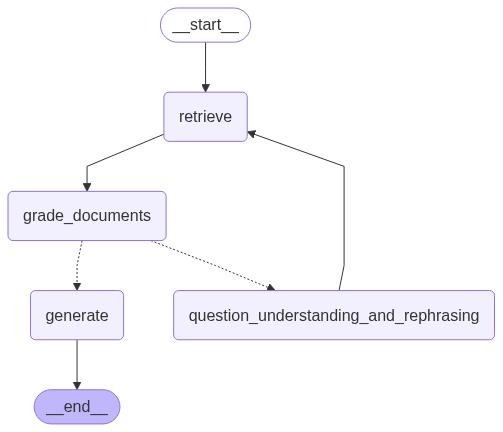

In [28]:
# Build the graph
graphB = StateGraph(GraphState)
# graph.add_node(START, "retrieve")
graphB.add_node("retrieve", retrieve)
graphB.add_node("generate", generate)
graphB.add_node("grade_documents", grade_documents)
graphB.add_node("question_understanding_and_rephrasing", question_understanding_and_rephrasing)

# # Add edges (transitions)
graphB.add_edge(START, "retrieve")
# graph.add_edge("retrieve", "generate")
graphB.add_edge("retrieve", "grade_documents")
graphB.add_conditional_edges("grade_documents", decide_generation, 
                            {
                                "generate": "generate",
                                "question_understanding_and_rephrasing": "question_understanding_and_rephrasing"
                            })
graphB.add_edge("question_understanding_and_rephrasing", "retrieve")
# graph.add_edge("question_understanding_and_rephrasing", "grade_documents")


graphB.add_edge("generate", END)



# Compile the graph
graph_runnableB = graphB.compile()

from IPython.display import Image, display

try:
    display(Image(graph_runnableB.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [32]:
for question in questions:
    initial_state = {"question": question}
    final_state = graph_runnableB.invoke(initial_state)
    if final_state["generation"] is None:
        print(f"No answer generated for question: {question}")
        continue
    else:
        # Print results
        print("Question:", final_state["question"])
        print("Generated Answer:", final_state["generation"])
    # print("Retrieved Documents:", final_state["documents"])
    # print("Original Question:", final_state["question"])
    # print("Document Scores:", final_state["scores"])
    print("\n---\n")
# Run the graph
# initial_state = {"question": "advice for an child having heart attack"}
# final_state = graph_runnableB.invoke(initial_state)

# # Print results
# print("Generated Answer:", final_state["generation"])
# print("Retrieved Documents:", final_state["documents"])
# print("Original Question:", final_state["question"])
# rephrased question
# print("Rephrased Question:", final_state["question"])
# print("Document Scores:", final_state["scores"])

---Retrieving documents---
---Grading documents---
binary_score='no'
binary_score='yes'
binary_score='no'
binary_score='no'
binary_score='no'
---Deciding whether to generate an answer---
--relevant documents found, generating the answer--
---Generating answer---
Question: Why does Harry accuse Remus Lupin of being a coward?
Generated Answer: Harry accuses Remus Lupin of being a coward because he believes Lupin is abandoning his child for the sake of adventure, contrasting it with his father's sacrifice.

---

---Retrieving documents---
---Grading documents---
binary_score='no'
binary_score='no'
binary_score='no'
binary_score='no'
binary_score='no'
---Deciding whether to generate an answer---
--no relevant document found or less context found, rephrasing the question--
---Understanding and rephrasing question---
---Retrieving documents---
---Grading documents---
binary_score='no'
binary_score='no'
binary_score='no'
binary_score='no'
binary_score='no'
---Deciding whether to generate an a

KeyboardInterrupt: 

In [ ]:
#### Answer grader node

# Data model
class GradeAnswer(BaseModel):
    """Binary score to assess answer addresses question."""

    binary_score: str = Field(
        description="Answer addresses the question, 'yes' or 'no'"
    )


def answer_grader(state):
    """Node for grading the quality and accuracy of generated answers."""
    print("---Grading the answer---")
    question = state["question"]
    generation = state["generation"]
    documents = state["documents"]

    # Comprehensive system prompt for answer evaluation
    system = """You are an expert evaluator assessing the quality of AI-generated answers.
    
    You will be given:
    1. The original user question
    2. The retrieved context documents used to answer the question
    3. The generated answer
    
    Your task is to evaluate whether the answer meets ALL of the following criteria:
    - ACCURACY: The answer contains ONLY information that is supported by the provided context documents
    - COMPLETENESS: The answer addresses the main aspects of the user's question
    - RELEVANCE: The answer stays focused on what was asked and doesn't include unnecessary information
    - TRUTHFULNESS: The answer doesn't contain any hallucinations (made-up information not in the documents)
    - COHERENCE: The answer is well-structured, logical, and easy to understand
    
    Return a binary judgment:
    - "yes" if the answer meets all criteria above
    - "no" if the answer fails on any criterion, especially if it contains hallucinations
    
    IMPORTANT: Be strict about hallucinations. If the answer contains ANY information not supported by the documents, grade it "no".
        """
    grade_prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system),
            ("human", "Question: {question}\n\n Set of facts/retrieved documents {documents}\n\n Generated Answer: {generation}"),
        ]
    )

    structured_llm_grader = llm.with_structured_output(GradeAnswer)
    answer_grader_chain = grade_prompt | structured_llm_grader
    result = answer_grader_chain.invoke({"question": question, "generation": generation, "documents": documents})

    return result.binary_score

    # if result.binary_score == "yes":
    #     print("--Answer is accurate, complete, relevant, truthful, and coherent.--")
    #     return {"answer_grade": "yes"} 
    # else:
    #     print("--Answer is inaccurate, incomplete, irrelevant, untruthful, or incoherent. Retrying with paraphrasing.--")
    #     return {"answer_grade": "no"}
    
# edge
def decide_final_answer(state):
    """
    Decide whether to use the generated answer or regenerate.
    """

    
    print("---Deciding on final answer---")

    answer_grade =  answer_grader(state)

    if answer_grade == "yes":
        print("--Answer is accurate, complete, relevant, truthful, and coherent.--")
        return "useful"
    else:
        print("--Answer is inaccurate, incomplete, irrelevant, untruthful, or incoherent. Retrying with paraphrasing.--")
        return "question_understanding_and_rephrasing"
    


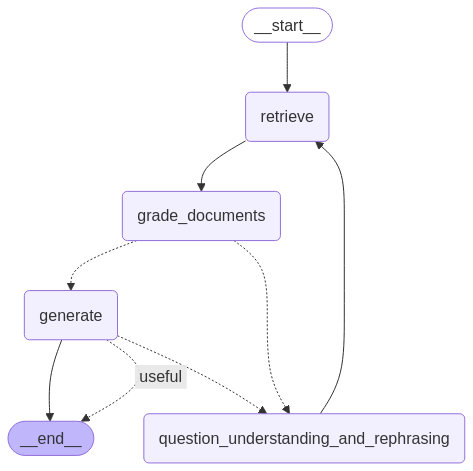

In [27]:
# Build the graph
graphC = StateGraph(GraphState)
# graph.add_node(START, "retrieve")
graphC.add_node("retrieve", retrieve)
graphC.add_node("generate", generate)
graphC.add_node("grade_documents", grade_documents)
graphC.add_node("question_understanding_and_rephrasing", question_understanding_and_rephrasing)

# # Add edges (transitions)
graphC.add_edge(START, "retrieve")
# graph.add_edge("retrieve", "generate")
graphC.add_edge("retrieve", "grade_documents")
graphC.add_conditional_edges("grade_documents", decide_generation, 
                            {
                                "generate": "generate",
                                "question_understanding_and_rephrasing": "question_understanding_and_rephrasing"
                            })
graphC.add_edge("question_understanding_and_rephrasing", "retrieve")
graphC.add_conditional_edges("generate", decide_final_answer,
                            {
                                "useful": END,
                                "question_understanding_and_rephrasing": "question_understanding_and_rephrasing"
                            })




graphC.add_edge("generate", END)



# Compile the graph
graph_runnableC = graphC.compile()

from IPython.display import Image, display

try:
    display(Image(graph_runnableC.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

##### TO-DO: Stop the loop after two iterations
- probably add iter_count to state and check important nodes that they dont exceed more than 2
- or create a consitional edge to keep tract of all the loops
- or combine both:

<!-- class GraphState(TypedDict):
    question: str
    iterations: int

def retrieve(state: GraphState):
        # Retrieval logic here
        return {"iterations": state["iterations"] + 1}

def route_to_next_step(state: GraphState):
        # Check if we should continue or end
        if state["iterations"] >= 2:
            return END
        return "grade_documents"

Add conditional edge to control iterations
    workflow.add_conditional_edges(
        "generate", 
        route_to_next_step
    )


In [37]:
# Run the graph
initial_state = {"question": "what are the main components Asynchronous one-step Q-learning "}
final_state = graph_runnableC.invoke(initial_state)

# Print results
print("Generated Answer:", final_state["generation"])
print("Retrieved Documents:", final_state["documents"])
print("Original Question:", final_state["question"])
# rephrased question
# print("Rephrased Question:", final_state["question"])
# print("Document Scores:", final_state["scores"])

---Retrieving documents---
---Grading documents---
binary_score='yes'
binary_score='no'
binary_score='yes'
binary_score='no'
binary_score='no'
---Deciding whether to generate an answer---
--relevant documents found, generating the answer--
---Generating answer---
---Deciding on final answer---
---Grading the answer---


c:\Users\newac\OneDrive\Desktop\Master\.venv\Lib\site-packages\langchain_openai\chat_models\base.py:1354: UserWarning: Received a Pydantic BaseModel V1 schema. This is not supported by method="json_schema". Please use method="function_calling" or specify schema via JSON Schema or Pydantic V2 BaseModel. Overriding to method="function_calling".
  warnings.warn(


--Answer is accurate, complete, relevant, truthful, and coherent.--
Generated Answer: The main components of Asynchronous one-step Q-learning include the use of multiple parallel actor-learners to explore different parts of the environment, which helps reduce correlations in updates. It employs a target network to stabilize learning by holding it fixed for several updates before refreshing it with current weights. Additionally, the algorithm does not rely on experience replay, allowing for on-policy reinforcement learning methods to be used effectively.
Retrieved Documents: [{'document': Document(id='92fcbf0e-f758-4025-89cc-94564b39e34b', metadata={'page': 6, 'source': 'papers\\1602.01783v1.pdf'}, page_content='speciﬁc target networks instead of using a single shared target network as in Algorithm 1.\nAnother choice is which network is used for selecting actions, the model network with\nparameters θ or the target network with parameters θ−. However, we found that these\nmodiﬁcation led